# Credit Card Fraud Detection

This notebook implements a credit card fraud detection system. It includes data preprocessing, exploratory data analysis, feature engineering, model building, and evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('/Users/shahid/Downloads/fraudTest.csv')

# If the first column is unnamed, rename it or drop it
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Display dataset overview
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nSample data:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset Overview:
Shape: (555719, 22)

Sample data:
  trans_date_trans_time            cc_num  \
0   2020-06-21 12:14:25  2291163933867244   
1   2020-06-21 12:14:33  3573030041201292   
2   2020-06-21 12:14:53  3598215285024754   
3   2020-06-21 12:15:15  3591919803438423   
4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street        city  ...      lat  \
0   Elliott      M            351 Darlene Green    Columbia  ...  33.9659   
1  Williams      F             3638 Marsh Union     Altonah  ...  40.3207   
2

## Data Cleaning and Preprocessing

In [3]:
# Data Cleaning and Preprocessing
print("\n--- Data Cleaning and Preprocessing ---")

# Convert trans_date_trans_time into separate date, hour, day_of_week fields
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date'] = df['trans_date_trans_time'].dt.date
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['trans_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_night_transaction'] = df['trans_hour'].apply(lambda x: 1 if x >= 22 or x <= 6 else 0)

# Calculate age from dob
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (datetime.now() - df['dob']).dt.days // 365


--- Data Cleaning and Preprocessing ---


In [4]:
# Calculate distance between customer and merchant using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

df['distance_to_merchant'] = df.apply(
    lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), 
    axis=1
)

In [5]:
# Log transformation of amount
df['amt_log'] = np.log1p(df['amt'])

# Bin amount into ranges
df['amt_bin'] = pd.qcut(df['amt'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# Drop or anonymize personal identifiers
cols_to_drop = ['cc_num', 'first', 'last', 'street', 'dob', 'trans_num', 'unix_time']
df_clean = df.drop(cols_to_drop, axis=1)

print("Cleaned dataframe shape:", df_clean.shape)

Cleaned dataframe shape: (555719, 24)


## Exploratory Data Analysis (EDA)


--- Exploratory Data Analysis ---


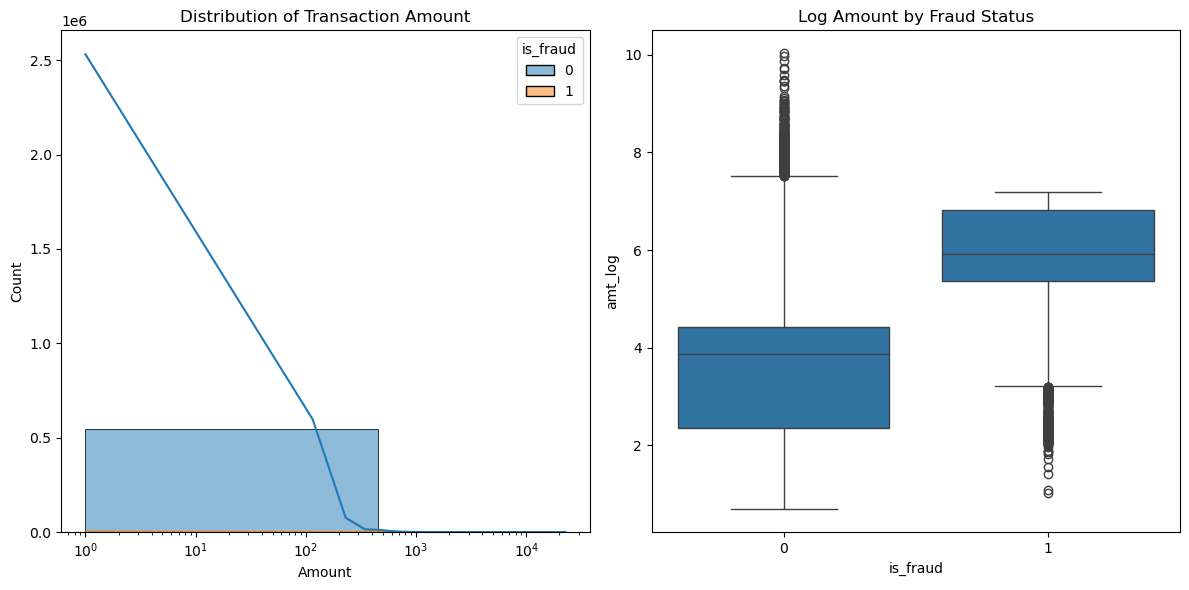

In [6]:
# Exploratory Data Analysis (EDA)
print("\n--- Exploratory Data Analysis ---")

# Distribution of transaction amount for fraud vs non-fraud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_clean, x='amt', hue='is_fraud', bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean, x='is_fraud', y='amt_log')
plt.title('Log Amount by Fraud Status')
plt.tight_layout()
plt.show()

In [7]:
# Most common category and state for fraud cases
fraud_df = df_clean[df_clean['is_fraud'] == 1]

print("\nTop 5 categories with highest fraud cases:")
print(fraud_df['category'].value_counts().head())

print("\nTop 5 states with highest fraud cases:")
print(fraud_df['state'].value_counts().head())


Top 5 categories with highest fraud cases:
category
shopping_net     506
grocery_pos      485
misc_net         267
shopping_pos     213
gas_transport    154
Name: count, dtype: int64

Top 5 states with highest fraud cases:
state
NY    175
PA    114
TX    113
CA     76
IL     76
Name: count, dtype: int64


In [8]:
# Average fraud rate by job, gender, and hour of day
print("\nFraud rate by gender:")
gender_fraud = df_clean.groupby('gender')['is_fraud'].mean() * 100
print(gender_fraud)

print("\nTop 5 jobs with highest fraud rate:")
job_fraud = df_clean.groupby('job')['is_fraud'].mean() * 100
print(job_fraud.sort_values(ascending=False).head())

print("\nFraud rate by hour of day:")
hour_fraud = df_clean.groupby('trans_hour')['is_fraud'].mean() * 100
print(hour_fraud)


Fraud rate by gender:
gender
F    0.381782
M    0.391097
Name: is_fraud, dtype: float64

Top 5 jobs with highest fraud rate:
job
Engineer, water                    100.000000
Operational investment banker      100.000000
Software engineer                  100.000000
Horticultural consultant             5.633803
Accountant, chartered certified      5.529954
Name: is_fraud, dtype: float64

Fraud rate by hour of day:
trans_hour
0     1.035641
1     0.915443
2     0.926130
3     1.065993
4     0.082988
5     0.111626
6     0.077322
7     0.088408
8     0.055577
9     0.077580
10    0.066486
11    0.093985
12    0.060634
13    0.049684
14    0.049638
15    0.074872
16    0.073522
17    0.057013
18    0.107139
19    0.085944
20    0.128650
21    0.095728
22    1.937438
23    1.868185
Name: is_fraud, dtype: float64


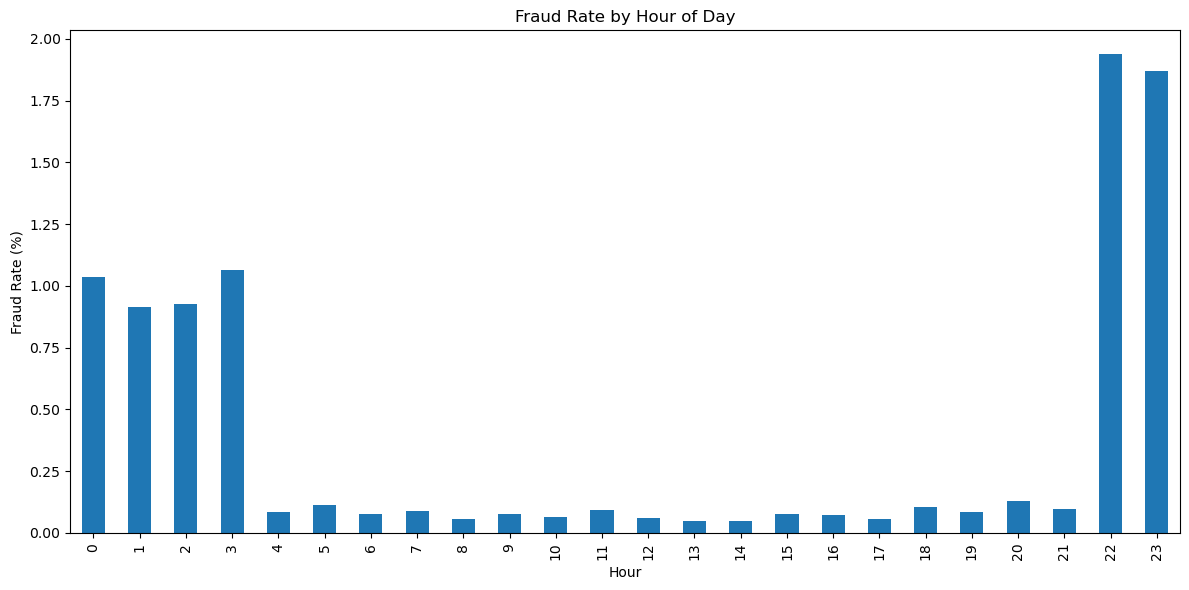

In [9]:
# Visualize fraud rate by hour
plt.figure(figsize=(12, 6))
hour_fraud.plot(kind='bar')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

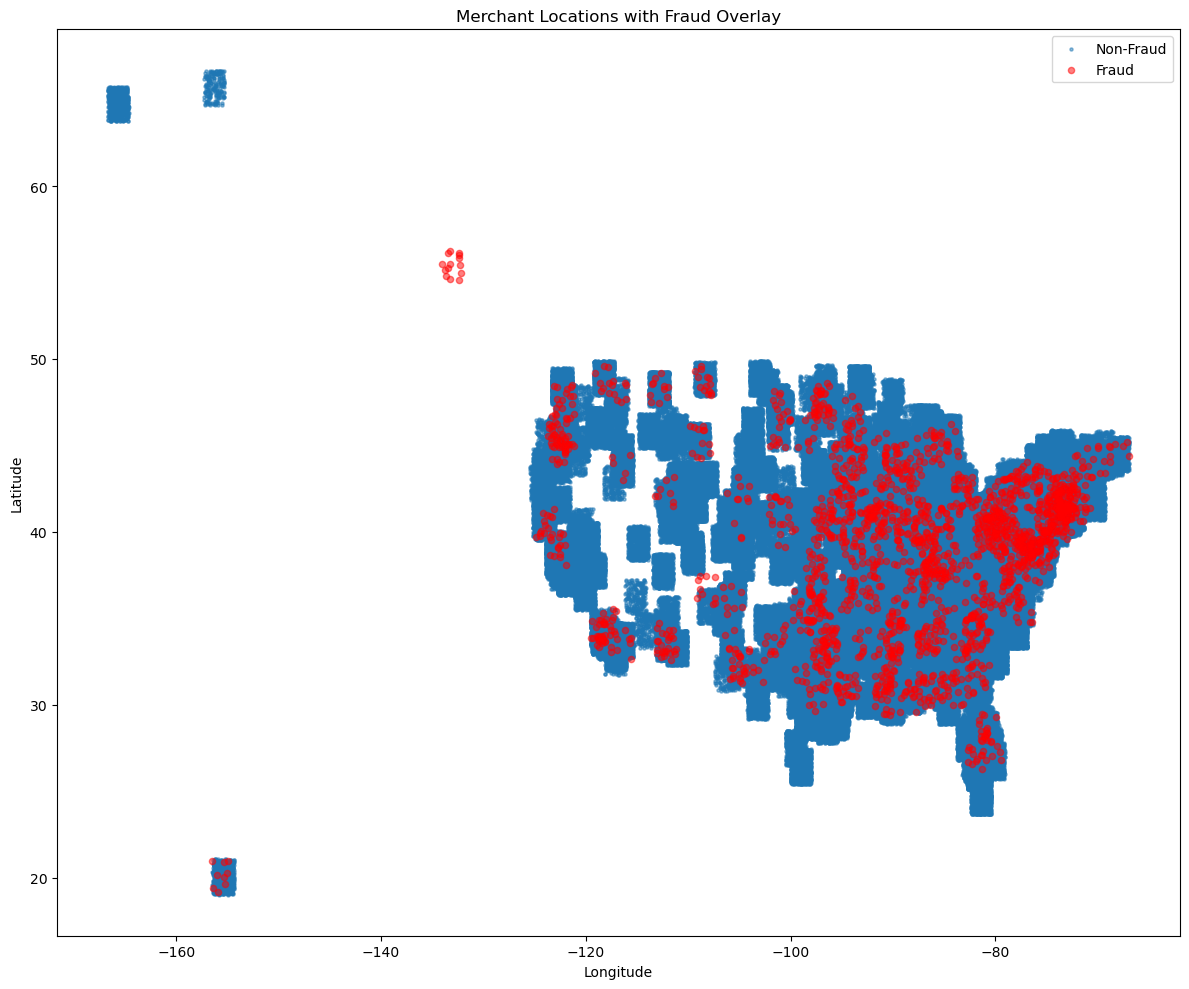

In [10]:
# Map merchant locations and overlay fraud hotspots
plt.figure(figsize=(12, 10))
plt.scatter(df_clean[df_clean['is_fraud']==0]['merch_long'], 
            df_clean[df_clean['is_fraud']==0]['merch_lat'], 
            alpha=0.5, s=5, label='Non-Fraud')
plt.scatter(df_clean[df_clean['is_fraud']==1]['merch_long'], 
            df_clean[df_clean['is_fraud']==1]['merch_lat'], 
            alpha=0.5, s=20, c='red', label='Fraud')
plt.title('Merchant Locations with Fraud Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.show()

## Feature Engineering and Model Preparation

In [11]:
# Feature Engineering
print("\n--- Feature Engineering ---")

# Prepare data for modeling
# Separate features and target
X = df_clean.drop('is_fraud', axis=1)
y = df_clean['is_fraud']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove date columns from numerical
date_cols = ['trans_date', 'trans_date_trans_time']
numerical_cols = [col for col in numerical_cols if col not in date_cols]

# Create preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


--- Feature Engineering ---


In [12]:
# Model Building
print("\n--- Model Building ---")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Fraud cases in training set: {sum(y_train)}")
print(f"Fraud cases in testing set: {sum(y_test)}")

# Define models
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ]),
    
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train), random_state=42))
    ])
}


--- Model Building ---
Training set shape: (444575, 23)
Testing set shape: (111144, 23)
Fraud cases in training set: 1716
Fraud cases in testing set: 429


## Model Training and Evaluation

In [13]:
# Model Training and Evaluation
print("\n--- Model Training and Evaluation ---")

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }
    
    # Print classification report
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)


--- Model Training and Evaluation ---

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.9778
Precision: 0.1333
Recall: 0.8648
F1 Score: 0.2309
ROC AUC: 0.9888
PR AUC: 0.4042

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    110715
           1       0.13      0.86      0.23       429

    accuracy                           0.98    111144
   macro avg       0.57      0.92      0.61    111144
weighted avg       1.00      0.98      0.99    111144


Confusion Matrix:
[[108302   2413]
 [    58    371]]

Training Random Forest...

Random Forest Results:
Accuracy: 0.9984
Precision: 0.9189
Recall: 0.6340
F1 Score: 0.7503
ROC AUC: 0.9934
PR AUC: 0.8545

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.92      0.63      0.75       429

    accuracy                           1.00    111144
   m

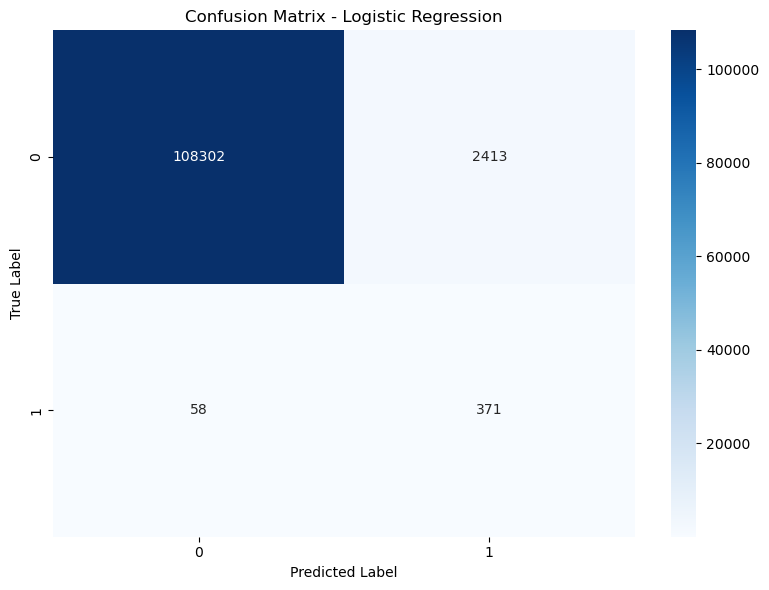

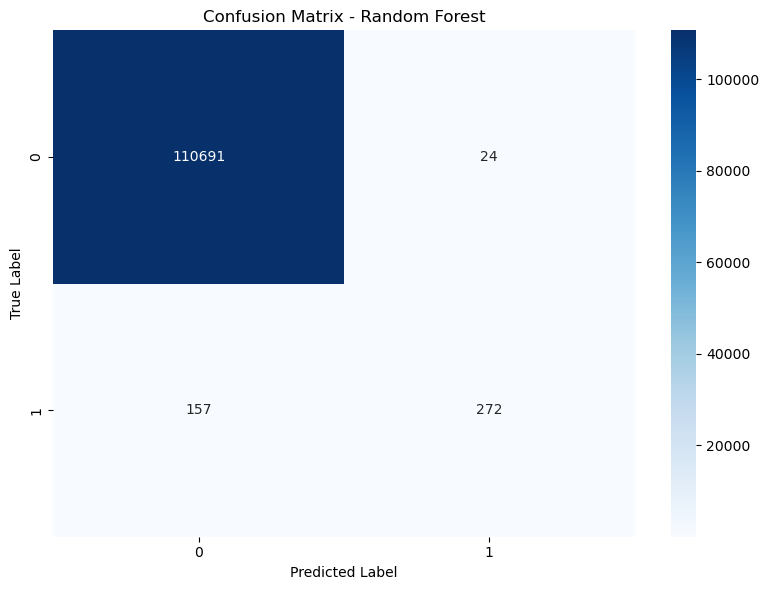

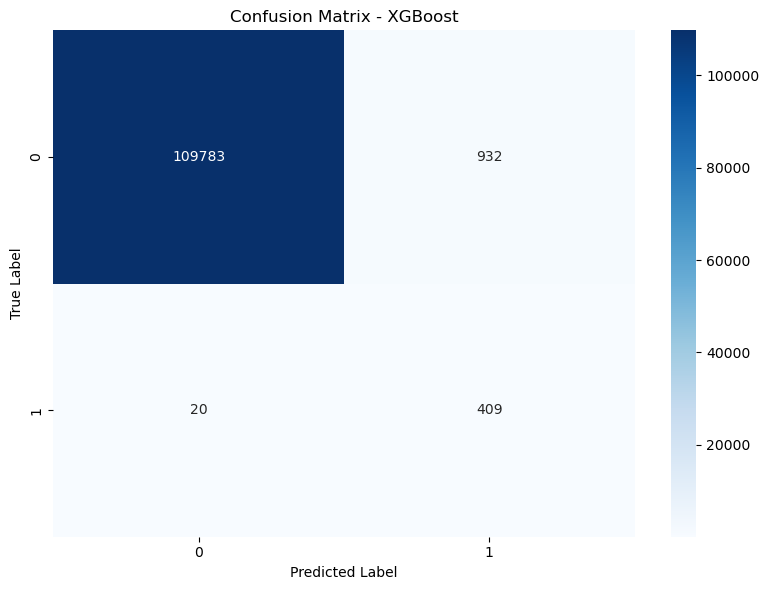

In [14]:
# Plot confusion matrices for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [15]:
# Cross-validation for each model
for name, model in models.items():
    print(f"\nPerforming cross-validation for {name}...")
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"Cross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f}")


Performing cross-validation for Logistic Regression...
Cross-validation ROC AUC scores: [0.86390578 0.81353914 0.69927356 0.64545285 0.81691778]
Mean CV ROC AUC: 0.7678

Performing cross-validation for Random Forest...
Cross-validation ROC AUC scores: [0.95181157 0.91417553 0.90783421 0.88975556 0.95815552]
Mean CV ROC AUC: 0.9243

Performing cross-validation for XGBoost...
Cross-validation ROC AUC scores: [0.98507417 0.98999165 0.98226751 0.98073582 0.98608255]
Mean CV ROC AUC: 0.9848


## Hyperparameter Tuning

In [16]:
# Hyperparameter Tuning for the best model
print("\n--- Hyperparameter Tuning ---")

# Find the best model based on ROC AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
print(f"Best model: {best_model_name} with ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Hyperparameter tuning for the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
else:  # XGBoost
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__n_estimators': [100, 200]
    }

# Create grid search
grid_search = GridSearchCV(
    models[best_model_name],
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit grid search
print(f"Tuning {best_model_name}...")
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:")
print(grid_search.best_params_)


--- Hyperparameter Tuning ---
Best model: XGBoost with ROC AUC: 0.9976
Tuning XGBoost...
Best parameters:
{'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}


In [17]:
# Evaluate tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)
y_prob_tuned = tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

# Print tuned model results
print("\nTuned Model Results:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"ROC AUC: {roc_auc_tuned:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))


Tuned Model Results:
Accuracy: 0.9950
Precision: 0.4322
Recall: 0.9441
F1 Score: 0.5930
ROC AUC: 0.9964

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.43      0.94      0.59       429

    accuracy                           0.99    111144
   macro avg       0.72      0.97      0.80    111144
weighted avg       1.00      0.99      1.00    111144



## Feature Importance Analysis

In [18]:
# Feature Importance Analysis
print("\n--- Feature Importance Analysis ---")

if best_model_name == 'Logistic Regression':
    # For logistic regression, get coefficients
    feature_names = (
        numerical_cols + 
        list(tuned_model.named_steps['preprocessor']
             .named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(categorical_cols))
    )
    coefficients = tuned_model.named_steps['classifier'].coef_[0]
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
    
elif best_model_name == 'Random Forest' or best_model_name == 'XGBoost':
    # For tree-based models, get feature importance
    feature_names = (
        numerical_cols + 
        list(tuned_model.named_steps['preprocessor']
             .named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(categorical_cols))
    )
    importances = tuned_model.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)


--- Feature Importance Analysis ---


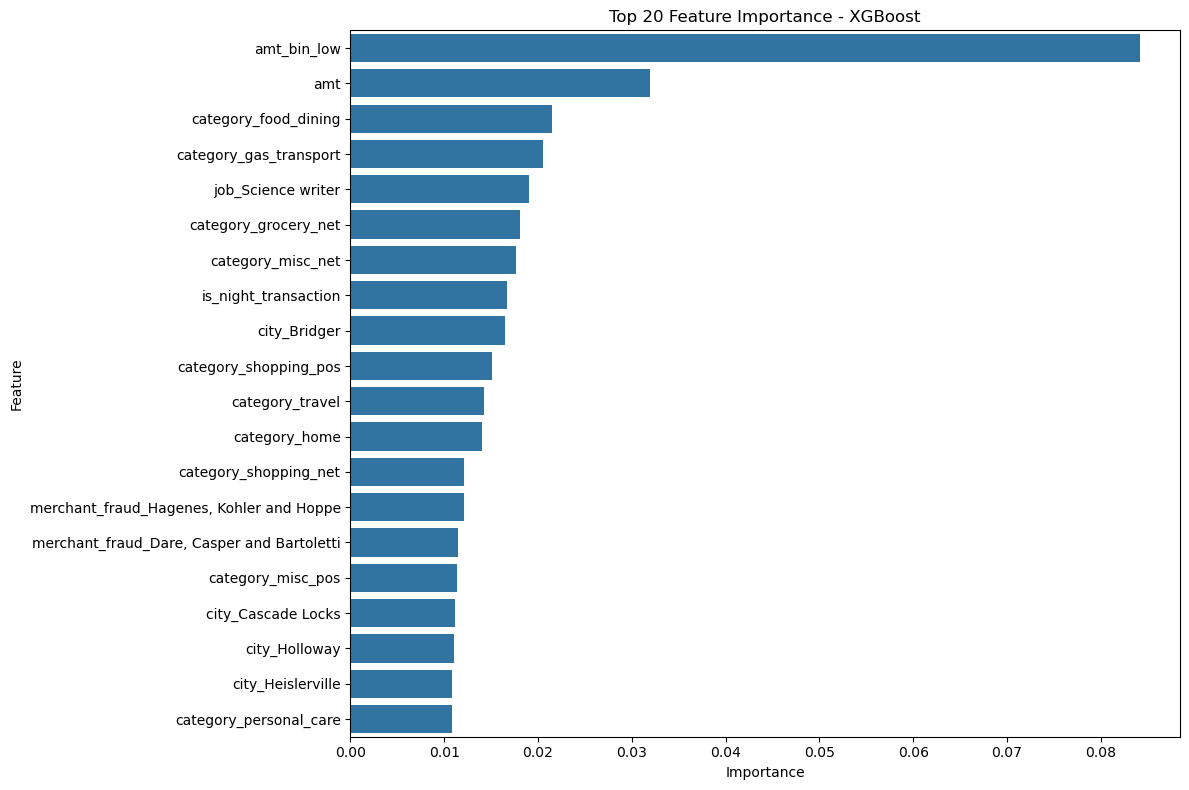


Top 10 most important features:
                     Feature  Importance
2293             amt_bin_low    0.084235
0                        amt    0.031918
706     category_food_dining    0.021535
707   category_gas_transport    0.020530
2013      job_Science writer    0.018994
708     category_grocery_net    0.018075
713        category_misc_net    0.017689
8       is_night_transaction    0.016650
813             city_Bridger    0.016516
717    category_shopping_pos    0.015100


In [19]:
# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title(f'Top 20 Feature Importance - {best_model_name}')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))

## Summary and Conclusion

In [20]:
# Summary and Conclusion
print("\n--- Summary and Conclusion ---")
print("Model Performance Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}: ROC AUC = {metrics['roc_auc']:.4f}, PR AUC = {metrics['pr_auc']:.4f}, F1 = {metrics['f1']:.4f}")

print(f"\nBest Model: {best_model_name}")
print(f"After tuning: ROC AUC = {roc_auc_tuned:.4f}, F1 = {f1_tuned:.4f}")

print("\nKey Findings:")
print("1. The most important features for fraud detection are:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print(f"2. Fraud rate by gender: {gender_fraud.to_dict()}")
print(f"3. Top fraud categories: {fraud_df['category'].value_counts().head(3).to_dict()}")
print(f"4. Top fraud states: {fraud_df['state'].value_counts().head(3).to_dict()}")
print(f"5. Fraud rate is {'higher' if hour_fraud[22:24].mean() > hour_fraud.mean() else 'lower'} during night hours")
print(f"6. Average distance to merchant for fraud cases: {fraud_df['distance_to_merchant'].mean():.2f} km")

print("\nRecommendations:")
print("1. Implement real-time fraud detection using the tuned model")
print("2. Focus monitoring on high-risk categories and states")
print("3. Apply additional verification for transactions with unusual distance between customer and merchant")
print("4. Consider time-based risk scoring with higher scrutiny during peak fraud hours")
print("5. Regularly retrain the model with new data to adapt to evolving fraud patterns")


--- Summary and Conclusion ---
Model Performance Comparison:
Logistic Regression: ROC AUC = 0.9888, PR AUC = 0.4042, F1 = 0.2309
Random Forest: ROC AUC = 0.9934, PR AUC = 0.8545, F1 = 0.7503
XGBoost: ROC AUC = 0.9976, PR AUC = 0.8404, F1 = 0.4621

Best Model: XGBoost
After tuning: ROC AUC = 0.9964, F1 = 0.5930

Key Findings:
1. The most important features for fraud detection are:
   - amt_bin_low: 0.0842
   - amt: 0.0319
   - category_food_dining: 0.0215
   - category_gas_transport: 0.0205
   - job_Science writer: 0.0190
2. Fraud rate by gender: {'F': 0.3817820431243153, 'M': 0.39109686524500364}
3. Top fraud categories: {'shopping_net': 506, 'grocery_pos': 485, 'misc_net': 267}
4. Top fraud states: {'NY': 175, 'PA': 114, 'TX': 113}
5. Fraud rate is higher during night hours
6. Average distance to merchant for fraud cases: 76.21 km

Recommendations:
1. Implement real-time fraud detection using the tuned model
2. Focus monitoring on high-risk categories and states
3. Apply additional v